In [1]:
import pandas as pd
import json
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import ipywidgets as widgets
import seaborn as sns
import IPython.display as ipd


In [2]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:60% !important; }</style>"))

C:\Users\mdfai\AppData\Local\Temp\ipykernel_16732\3710136257.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


### The Next cell basically manages the dataset to have similar country names. Many Countries are not in the json file that we have. So we are getting rid of it. 

In [3]:
# Load the CSV file

pop_raw = pd.read_csv('./population-and-demography.csv')
male_pop_raw = pd.read_csv('./Male - population-and-demography.csv')
female_pop_raw = pd.read_csv('./female - population-and-demography.csv')
life_expec_raw = pd.read_csv('./life expectancy - population-and-demography.csv')
death_rate_raw = pd.read_csv('./death rate - population-and-demography.csv')
birth_rate_raw = pd.read_csv('./birth rate - population-and-demography.csv')
child_death_raw = pd.read_csv('./child mortality rate - population-and-demography.csv')
other_data_raw = pd.read_csv('./Other data - Copy.csv')


                   
# List of non-country entries created by chat GPT 
non_countries = [
    'Africa (UN)', 'Asia (UN)', 'Europe (UN)', 'High-income countries', 'Land-locked developing countries (LLDC)', 
    'Latin America and the Caribbean (UN)', 'Least developed countries', 'Less developed regions', 
    'Less developed regions, excluding China', 'Less developed regions, excluding least developed countries', 
    'Low-income countries', 'Lower-middle-income countries', 'More developed regions', 'Northern America (UN)',
    'Oceania (UN)', 'Small island developing states (SIDS)', 'Upper-middle-income countries', 'World', 'Aruba', 'Barbados', 'Burundi', 'Saint Barthelemy', 'Bermuda', 'Brunei',
    'Bonaire Sint Eustatius and Saba', "Cote d'Ivoire", 'Curacao', 'Falkland Islands',
    'French Guiana', 'Guernsey', 'Guam', 'Jersey', 'Kiribati', 'Saint Martin (French part)',
    'Northern Mariana Islands', 'Nauru', 'Niue', 'Reunion', 'Rwanda',
    'Sint Maarten (Dutch part)', 'Tokelau', 'Turkey', 'Kosovo', 'Yemen' 
]

# Filter out the non-country entries
pop = pop_raw[~pop_raw['Country name'].isin(non_countries)]
male_pop = male_pop_raw[~male_pop_raw['Country name'].isin(non_countries)]
female_pop = female_pop_raw[~female_pop_raw['Country name'].isin(non_countries)]
life_expec_raw2 = life_expec_raw[~life_expec_raw['Country name'].isin(non_countries)]
death_rate_raw2 = death_rate_raw[~death_rate_raw['Country name'].isin(non_countries)]
birth_rate_raw2 = birth_rate_raw [~birth_rate_raw ['Country name'].isin(non_countries)]
child_death_raw2 = child_death_raw[~child_death_raw['Country name'].isin(non_countries)]
other_data_raw2 = other_data_raw[~other_data_raw['Country name'].isin(non_countries)]

#Filter out 'Vatican' from some files
death_rate = death_rate_raw2[death_rate_raw2['Country name'] != 'Vatican']
birth_rate = birth_rate_raw2[birth_rate_raw2['Country name'] != 'Vatican']
child_death = child_death_raw2[child_death_raw2['Country name'] != 'Vatican']
life_expec = life_expec_raw2[life_expec_raw2['Country name'] != 'Vatican']
other_data = other_data_raw2[other_data_raw2['Country name'] != 'Vatican']


### In the next cell I only kept the column that I will use 

In [4]:
pop = pop[['Country name', 'Year', 'Population']]
male_pop = male_pop[['Country name', 'Year', 'Male population']]
female_pop = female_pop[['Country name', 'Year', 'Female population']]


### All the data we had didn't have any ISO3 code with them which we will use to make a link with our worl.json file. So we used chatGPT to create the ISO3 for every countyr. The prompt was "Here is the name of the countires. Now use your knowledge to give me the ISO3 and ISO2 for the countires and give me the list in a CSV file"

In [5]:
iso = pd.read_csv('./Country_with_ISO_Codes.csv')

### Creating a new dataset combining all the data

In [6]:
dataframes = {
    'pop': pop,
    'male_pop': male_pop,
    'female_pop': female_pop,
    'death_rate': death_rate,
    'birth_rate': birth_rate,
    'child_death': child_death
}


columns_to_take = [
    ['Country name', 'Year', 'Population'],
    ['Country name', 'Year', 'Male population'],
    ['Country name', 'Year', 'Female population'],
    ['Country name', 'Year', 'Death rate'],
    ['Country name', 'Year', 'Birth rate'],
    ['Country name', 'Year', 'Child mortality rate']
]

# Initialize an empty DataFrame
final_df = pd.DataFrame()

# Iterate over the datasets and columns
for dataset_name, columns in zip(dataframes.keys(), columns_to_take):
    df = dataframes[dataset_name][columns]
    if final_df.empty:
        final_df = df
    else:
        final_df = final_df.merge(df, on=['Country name', 'Year'], how='inner')


#Merging data with ISO        
final = final_df.merge(iso, on='Country name', how='left')

# final.to_csv('./final.csv', index=False)

### Merging data for heatmap with GEO JSON

In [7]:
# Load the GeoJSON data
world_geo = gpd.read_file('./world.json')

# Filter the population data for the year 2021
final_2021 = final[final['Year'] == 2021]

# Merge the population data with geographical data using ISO3 codes
merged_data = world_geo.merge(final_2021, left_on='id', right_on='ISO3')

# Applying a logarithmic scale to the population data
merged_data['Log_Population'] = np.log1p(merged_data['Population'])

# Convert the merged GeoDataFrame to a GeoJSON format
geojson_data = json.loads(merged_data.to_json())


### Creating Heat map for different data

In [8]:
# Create a Population Choropleth map using Altair
choropleth_map_pop = alt.Chart(alt.Data(values=geojson_data['features'])).mark_geoshape(
    stroke='white'
).encode(
    alt.Color('properties.Log_Population:Q', 
              scale=alt.Scale(scheme='reds'),
              title='Logarithmic Population',
              legend = None),
    tooltip=[
        alt.Tooltip('properties.Country name:N', title='Country'),
        alt.Tooltip('properties.Population:Q', title='Population')
    ]
).properties(
    title='Population',
    width=800,
    height=600
).project(
    type='naturalEarth1'
)


# Create a birth rate Choropleth map using Altair
choropleth_map_birth = alt.Chart(alt.Data(values=geojson_data['features'])).mark_geoshape(
    stroke='white'
).encode(
    alt.Color('properties.Birth rate:Q', 
              scale=alt.Scale(scheme='reds'),
              title='Birth rate',
              legend = None),
    tooltip=[
        alt.Tooltip('properties.Country name:N', title='Country'),
        alt.Tooltip('properties.Birth rate:Q', title='Birth rate')
    ]
).properties(
    title='Birth Rate',
    width=800,
    height=600
).project(
    type='naturalEarth1'
)

# Create a Mortality rate Choropleth map using Altair
choropleth_map_death = alt.Chart(alt.Data(values=geojson_data['features'])).mark_geoshape(
    stroke='white'
).encode(
    alt.Color('properties.Death rate:Q', 
              scale=alt.Scale(scheme='reds'),
              title='Mortality rate',
              legend = None),
    tooltip=[
        alt.Tooltip('properties.Country name:N', title='Country'),
        alt.Tooltip('properties.Death rate:Q', title='Mortality Rate')
    ]
).properties(
    title='Mortality rate',
    width=800,
    height=600
).project(
    type='naturalEarth1'
)

# Create a Child mortality rate Choropleth map using Altair
choropleth_map_child = alt.Chart(alt.Data(values=geojson_data['features'])).mark_geoshape(
    stroke='white'
).encode(
    alt.Color('properties.Child mortality rate:Q', 
              scale=alt.Scale(scheme='reds'),
              title='Child mortality rate',
              legend = None),
    tooltip=[
        alt.Tooltip('properties.Country name:N', title='Country'),
        alt.Tooltip('properties.Child mortality rate:Q', title='Child Mortality Rate')
    ]
).properties(
    title='Child mortality rate',
    width=800,
    height=600
).project(
    type='naturalEarth1'
)


### This cell is interactive where you can choose map to show it from the drop down

In [9]:
charts = {
    "Population": choropleth_map_pop,
    "Birth Rate": choropleth_map_birth,
    "Mortality Rate": choropleth_map_death,
    "Child Mortality Rate": choropleth_map_child
    # Add other charts here if needed
}

# Function to display the selected chart
def show_chart(chart_name):
    with chart_output:
        chart_output.clear_output(wait=True)
        display(charts[chart_name])

dropdown_output = widgets.Output()
chart_output = widgets.Output()

# Create a dropdown to select the chart
dropdown = widgets.Dropdown(options=charts.keys(), description='Select Chart:')


def on_dropdown_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        show_chart(change['new'])

dropdown.observe(on_dropdown_change, names='value')


with dropdown_output:
    display(dropdown)

with chart_output:
    display(charts[list(charts.keys())[0]])

# Display the output widgets
display(dropdown_output)
display(chart_output)

Output()

Output()

In [10]:
merged_df_1 = pd.merge(other_data, child_death, on = 'Country name')
merged_df_1 = merged_df_1[merged_df_1['Year'] == 2011]



chart = alt.Chart(merged_df_1).mark_circle(
    size=150, color = 'green', opacity = 0.5
).encode(
    x=alt.X('Literacy rate (2011)', title = 'Literacy rate', axis = alt.Axis(titleFont = 'Helvetica', titleFontSize = 14, labelFont = 'Helvetica'), scale=alt.Scale(zero=False)),
    y=alt.Y('Child mortality rate', title = 'Child Mortality Rate', axis = alt.Axis(titleFont = 'Helvetica', titleFontSize = 14, labelFont = 'Helvetica'), scale=alt.Scale(zero=False)),
    tooltip=['Country name', 'Literacy rate (2011)', 'Child mortality rate']  # Optional tooltips
).properties(
    width=600,
    height=400,
    title='Child Mortality vs Literacy Rate'
)



# rect_patch = alt.Chart(pd.DataFrame({'x': [0.5], 'y': [0.5], 'width': [0.5], 'height': [0.5]})).mark_rect(fill='lightblue', opacity=0.5).encode(
#     x=alt.X('x:O', axis=None),
#     y=alt.Y('y:O', axis=None),
#     x2='x2:O',
#     y2='y2:O'
# )

alt.themes.enable('latimes') 

combined = chart 
combined.display()





alt.Chart(...)

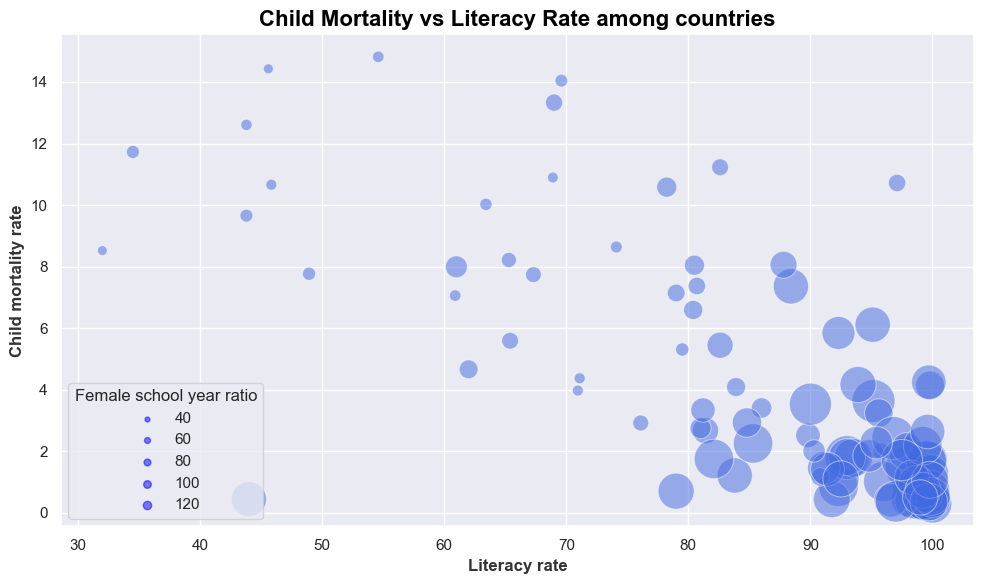

In [30]:
merged_df_1 = pd.merge(other_data, child_death, on = 'Country name')
merged_df_1 = merged_df_1[merged_df_1['Year'] == 2011]
scaling_factor = 5  
merged_df_1['Scaled female school ratio'] = merged_df_1['female school year ratio'] ** scaling_factor

# Create a scatter plot using columns from the DataFrame
sns.set_style("darkgrid")  # Set the style of the plot
sns.set_palette("deep")
plt.figure(figsize=(10, 6))  # Set the figure size

# Create the scatter plot with customizations

scatter_plot = sns.scatterplot(data=merged_df_1, x='Literacy rate (2011)', y='Child mortality rate', size = 'Scaled female school ratio', color='royalblue', marker='o', sizes=(50, 1000), alpha = 0.5)

# Customize title
scatter_plot.set_title('Child Mortality vs Literacy Rate among countries', fontsize=16, fontweight='bold', color='black')

# Customize x-axis label
scatter_plot.set_xlabel('Literacy rate', fontsize=12, fontweight='bold', color='black', alpha = 0.8)

# Customize y-axis label
scatter_plot.set_ylabel('Child mortality rate', fontsize=12, fontweight='bold', color='black', alpha = 0.8)

# Manually create a legend with original 'Female school ratio' values
# Select representative values for the legend
legend_values = [40, 60, 80, 100, 120]  # Example values, choose according to your dataset
legend_labels = [f'{v}' for v in legend_values]
legend_handles = [plt.scatter([], [], s=v*0.3, color='blue', alpha=0.5) for v in legend_values]

# Add the legend to the plot
scatter_plot.legend(handles=legend_handles, labels=legend_labels, title='Female school year ratio', loc='lower left')


# Show the plot
plt.tight_layout()  # Ensure proper spacing
plt.show()

In [12]:
countries_to_remove2 = ['Australia', 'United States', 'Luxembourg']
merged_df_1_aus = merged_df_1[~merged_df_1['Country name'].isin(countries_to_remove2)]


chart2 = alt.Chart(merged_df_1_aus).mark_circle(
    size=150, color = 'green', opacity = 0.5
).encode(
    x=alt.X('Literacy rate (2011)', title = 'Literacy rate', axis = alt.Axis(titleFont = 'Helvetica', titleFontSize = 14, labelFont = 'Helvetica'), scale=alt.Scale(zero=False)),
    y=alt.Y('Partner Violence (2018)', title = 'Partner Violence', axis = alt.Axis(titleFont = 'Helvetica', titleFontSize = 14, labelFont = 'Helvetica'), scale=alt.Scale(zero=False)),
    tooltip=['Country name', 'Literacy rate (2011)', 'Partner Violence (2018)']  # Optional tooltips
).properties(
    width=600,
    height=400,
    title='Literacy rate vs Partner Violence'
)
chart2.display()

alt.Chart(...)

In [13]:
chart3 = alt.Chart(merged_df_1).mark_circle(
    size=150, color = 'green', opacity = 0.5
).encode(
    x=alt.X('female school year ratio', title = 'Female school year ratio', axis = alt.Axis(titleFont = 'Helvetica', titleFontSize = 14, labelFont = 'Helvetica'), scale=alt.Scale(zero=False)),
    y=alt.Y('Partner Violence (2018)', title = 'GDP per capita', axis = alt.Axis(titleFont = 'Helvetica', titleFontSize = 14, labelFont = 'Helvetica'), scale=alt.Scale(zero=False)),
    tooltip=['Country name', 'female school year ratio', 'Partner Violence (2018)']  # Optional tooltips
).properties(
    width=600,
    height=400,
    title='Female school year ratio vs Partner Violence'
)


chart3.display()

alt.Chart(...)

In [14]:
chart4 = alt.Chart(merged_df_1).mark_circle(
    size=150, color = 'green', opacity = 0.5
).encode(
    x=alt.X('female school year ratio', title = 'Female school year ratio', axis = alt.Axis(titleFont = 'Helvetica', titleFontSize = 14, labelFont = 'Helvetica'), scale=alt.Scale(zero=False)),
    y=alt.Y('Democracy Index (2011)', title = 'Democracy Index', axis = alt.Axis(titleFont = 'Helvetica', titleFontSize = 14, labelFont = 'Helvetica'), scale=alt.Scale(zero=False)),
    tooltip=['Country name', 'female school year ratio', 'Democracy Index (2011)']  # Optional tooltips
).properties(
    width=600,
    height=400,
    title='Female school year ratio vs Democracy Index'
)


chart4.display()

alt.Chart(...)

In [15]:
chart5 = alt.Chart(merged_df_1).mark_circle(
    size=150, color = 'green', opacity = 0.5
).encode(
    x=alt.X('female school year ratio', title = 'Female school year ratio', axis = alt.Axis(titleFont = 'Helvetica', titleFontSize = 14, labelFont = 'Helvetica'), scale=alt.Scale(zero=False)),
    y=alt.Y('Democracy Index (2011)', title = 'Democracy Index', axis = alt.Axis(titleFont = 'Helvetica', titleFontSize = 14, labelFont = 'Helvetica'), scale=alt.Scale(zero=False)),
    tooltip=['Country name', 'female school year ratio', 'Democracy Index (2011)']  # Optional tooltips
).properties(
    width=600,
    height=400,
    title='Female school year ratio vs Democracy Index'
)


chart5.display()

alt.Chart(...)

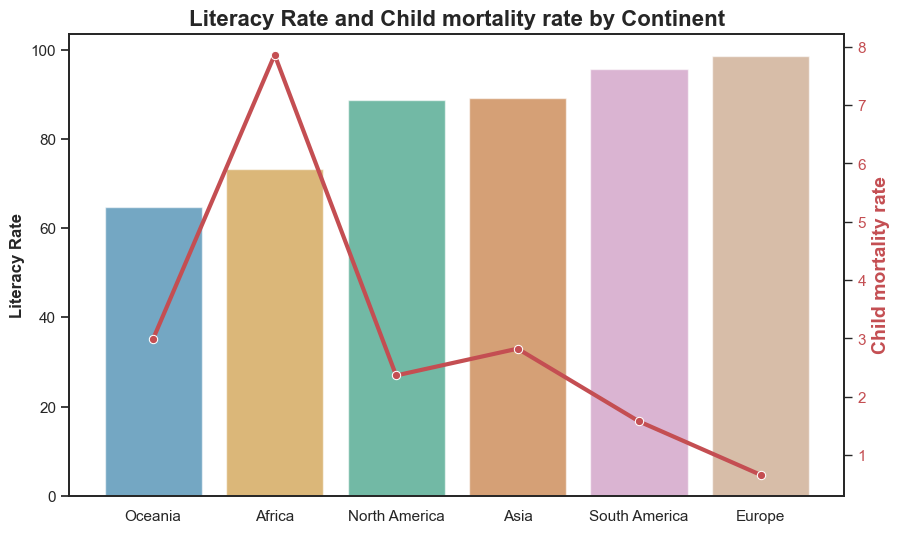

In [16]:
merged_df_1['Continent'] = merged_df_1['Continent'].str.strip()
comb_1 = merged_df_1.dropna(subset=['Continent', 'Literacy rate (2011)', 'Child mortality rate'])
average_values_by_continent = comb_1.groupby('Continent')[['Literacy rate (2011)', 'Child mortality rate']].mean()
average_values_by_continent = average_values_by_continent.sort_values(by='Literacy rate (2011)', ascending=True)

long_format_df = average_values_by_continent.reset_index().melt(id_vars='Continent', value_vars=['Literacy rate (2011)', 'Child mortality rate'])



# Setting a magazine style font
plt.rcParams.update({'font.family':'sans-serif', 'font.sans-serif':'sans-serif'})

# Removing the grid
sns.set_theme(style="white", rc={"axes.grid": False})

# Creating figure and axis for the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart for Literacy Rate with different colors
literacy_data = long_format_df[long_format_df['variable'] == 'Literacy rate (2011)']
sns.barplot(x='Continent', y='value', data=literacy_data, alpha=0.6, ax=ax1, palette="colorblind")
ax1.set_xlabel('', fontsize=12)
ax1.set_ylabel('Literacy Rate', fontsize=12, fontweight='bold')
ax1.tick_params(axis='y')
ax1.set_title('Literacy Rate and Child mortality rate by Continent', fontsize=16, fontweight='bold')

# Line plot for GDP per Capita
ax2 = ax1.twinx()
gdp_data = long_format_df[long_format_df['variable'] == 'Child mortality rate']
sns.lineplot(x='Continent', y='value', data=gdp_data, marker='o', ax=ax2, color='r', linewidth=3)
ax2.set_ylabel('Child mortality rate', fontsize=14, color='r', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='r', width = 1)

# Customizing the background
fig.patch.set_facecolor('white')
ax1.set_facecolor('white')

# Show plot
plt.show()

### Bubble chart of country 

In [17]:
other_data = other_data.dropna(subset=['Country name', 'Literacy rate (2011)', 'Life expectancy (2011)'])

other_data['Increased life expectancy'] = other_data['Life expectancy (2011)'].apply(lambda x: x**4)

other_data_sorted = other_data.sort_values(by='Literacy rate (2011)', ascending=True)

final_filtered = final[final['Year'] == 2011]

other_data_sorted = pd.merge(other_data_sorted, final_filtered[['Country name', 'ISO3']], on='Country name', how='left')

# other_data_sorted.to_csv('other_data_sorted.csv', index=False)

# Create a bubble chart
chart = alt.Chart(other_data_sorted).mark_circle().encode(
    x=alt.X('Life expectancy (2011):Q', axis=alt.Axis(ticks=False, labels=False, grid=False, title = None)),  # N indicates a nominal (categorical) data type
        y=alt.Y('Literacy rate (2011):Q', axis=alt.Axis(
        ticks=False, 
        labels=False, 
        grid=False, 
        title='Literacy rate',  # Set your title here
        titlePadding=10,  # Adjust the padding to move the title closer or further from the axis
        titleFontSize=16,  # Adjust font size as needed
        titleFont='Helvetica',  # Set the font family
        titleFontWeight='bold',  # Set the font weight
        titleAngle=180,  # Keep the title angle at 0 for horizontal text
        titleAlign='left',  # Align the title text ('left', 'center', 'right')
        titleY=-10,  # Adjust title Y position
        titleX=-60  # Adjust title X position
    )),  # Q indicates a quantitative data type
    size=alt.Size('Increased life expectancy:Q', scale=alt.Scale(domain=(0, 3000000)), legend = None),  # Use life expectancy for bubble sizes
    color=alt.Color('Country name:N', legend=None),  # Optional: color by country
    tooltip=['Country name:N', 'Literacy rate (2011):Q', 'Life expectancy (2011):Q']  # Show details on hover
).properties(
    width=1200,
    height=600,
    title=alt.TitleParams(
        text='Bubble Chart Showing Correlation Between Literacy Rate and Life Expectency', 
        fontSize=30, 
        color='Black', 
#         fontStyle='italic', 
        fontWeight='bold', 
        anchor='start',  # Options: 'start', 'middle', 'end'
        align='left'
    )    
).interactive()


# Create text labels
text_chart = alt.Chart(other_data_sorted).mark_text(align='center', baseline='middle', fontSize=8).encode(
    x='Life expectancy (2011):Q',
    y='Literacy rate (2011):Q',
    text='ISO3:N'
)

combined = chart + text_chart
combined

alt.LayerChart(...)

In [18]:
merged_df_1

,Country name,Continent,Literacy rate (2011),Inflation (2021),Life expectancy (2011),Democracy Index (2011),GDP per capita (2011),female school year ratio,Partner Violence (2018),Year,Child mortality rate,Scaled female school ratio
61,Afghanistan,Asia,32.00,0.525,61.0,24.8,551.0,22.9,35.0,2011,8.521891,6.297634e+06
133,Albania,Europe,83.80,5.930,78.1,58.1,3680.0,102.0,6.0,2011,1.217250,1.104081e+10
205,Algeria,Africa,81.41,15.700,74.7,34.4,3970.0,89.4,NaN,2011,2.672800,5.710677e+09
277,American Samoa,Oceania,NaN,0.905,NaN,NaN,12700.0,NaN,NaN,2011,1.093590,NaN
349,Andorra,Europe,NaN,22.100,81.9,NaN,41500.0,105.0,NaN,2011,0.696270,1.276282e+10
...,...,...,...,...,...,...,...,...,...,...,...,...
14821,Vietnam,Asia,95.40,2.780,73.3,29.6,2140.0,98.3,10.0,2011,2.283930,9.178413e+09
14893,Wallis and Futuna,Oceania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,1.431220,NaN
14965,Western Sahara,Africa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,4.484330,NaN
15037,Zambia,Africa,NaN,27.600,57.5,61.9,1220.0,83.4,28.0,2011,7.665200,4.034877e+09
